**Install Required Libraries**


In [ ]:
!pip install torch torchvision opencv-python matplotlib

**Upgrade ONNX and OpenVINO**


In [ ]:
!pip install --upgrade onnx openvino-dev
!pip install --upgrade openvino-dev onnx


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Copy Dataset from Google Drive to Local Directory**


In [ ]:
!cp -r /content/drive/MyDrive/Hdpe_pipe_new.v2 /content/dataset

**List Files in the Dataset Directory**


In [ ]:
!ls /content/dataset

Hdpe_pipe_new.v2  README.dataset.txt  README.roboflow.txt  train  valid


**Import Required Libraries for Faster R-CNN and COCO Dataset**


In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import cv2
import os
import json
import numpy as np
from pycocotools.coco import COCO


**Checking for Images Without Annotations in COCO Format**


In [ ]:
import json

# Load the fixed annotations JSON
annotation_file = "/content/dataset/train/_annotations.coco.json"

with open(annotation_file, "r") as f:
    coco_data = json.load(f)

# Find images with no annotations
image_ids_with_annotations = {ann["image_id"] for ann in coco_data["annotations"]}
all_image_ids = {img["id"] for img in coco_data["images"]}

missing_images = all_image_ids - image_ids_with_annotations

if missing_images:
    print("⚠️ Images with NO bounding boxes:", missing_images)
else:
    print("✅ All images have bounding boxes.")

⚠️ Images with NO bounding boxes: {28, 125}


**Displaying Categories from COCO JSON Annotations**


In [ ]:
print("Categories in COCO JSON:", coco_data["categories"])

Categories in COCO JSON: [{'id': 1, 'name': 'HDPE_Pipes', 'supercategory': 'Hdpe_pipe'}]


**Removing Images Without Annotations in COCO JSON**


In [ ]:
import json

# Load the fixed annotations JSON
annotation_file = "/content/dataset/train/_annotations.coco.json"

with open(annotation_file, "r") as f:
    coco_data = json.load(f)

# Remove images with no annotations
invalid_image_ids = {28, 125}
coco_data["images"] = [img for img in coco_data["images"] if img["id"] not in invalid_image_ids]

# Save the cleaned JSON
cleaned_annotation_file = "/content/dataset/train/annotations_cleaned.json"
with open(cleaned_annotation_file, "w") as f:
    json.dump(coco_data, f, indent=4)

print("✅ Cleaned COCO JSON saved:", cleaned_annotation_file)

✅ Cleaned COCO JSON saved: /content/dataset/train/annotations_cleaned.json


**Custom COCO Dataset for PyTorch Dataloader**


In [ ]:
class COCODataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())
        self.transform = transform

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.imgs[image_id]
        image_path = os.path.join(self.root_dir, image_info['file_name'])

        # Read image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0  # Normalize

        # Load annotations
        annotations = self.coco.loadAnns(self.coco.getAnnIds(imgIds=image_id))
        boxes = []
        labels = []
        for ann in annotations:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"])

        target = {"boxes": torch.tensor(boxes, dtype=torch.float32), "labels": torch.tensor(labels, dtype=torch.int64)}

        return image, target

    def __len__(self):
        return len(self.image_ids)

# Initialize dataset & dataloader
train_dataset = COCODataset(root_dir='/content/dataset/train', annotation_file='/content/dataset/train/annotations_cleaned.json')
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))



loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


 **Load and Modify Faster R-CNN for Custom COCO Dataset**


In [ ]:
# Load Faster R-CNN with pre-trained weights
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier to match the number of classes
num_classes = len(train_dataset.coco.cats) + 1  # COCO classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Training Faster R-CNN on Custom COCO Dataset**


In [ ]:
# Define optimizer and training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, targets in train_dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")


Epoch [1/5], Loss: 95.5953
Epoch [2/5], Loss: 69.0834
Epoch [3/5], Loss: 62.3664
Epoch [4/5], Loss: 54.7719
Epoch [5/5], Loss: 52.2660


**Export Faster R-CNN Model to ONNX Format**


In [ ]:
dummy_input = torch.randn(1, 3, 800, 800).to(device)
torch.onnx.export(model.to(device), dummy_input, "faster_rcnn.onnx", opset_version=11)

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:4511: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.tensor(scale_factors[i], dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/torchvision/ops/boxes.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
/usr/local/lib/python3.11/dist-packages/torchvision/ops/boxes.py:168: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_y = torch.min(boxes_y, torch.tensor(height, dty

**Convert ONNX Model to OpenVINO IR Format**


In [ ]:
import subprocess

subprocess.run("mo --input_model faster_rcnn.onnx --output_dir ./model_ir", shell=True, check=True)



CompletedProcess(args='mo --input_model faster_rcnn.onnx --output_dir ./model_ir', returncode=0)

**Load and Compile OpenVINO IR Model for Inference**


In [ ]:
from openvino.runtime import Core

ie = Core()
model_path = "model_ir/faster_rcnn.xml"
compiled_model = ie.compile_model(model_path, "CPU")


**Preprocess Image and Run Inference with OpenVINO**


In [ ]:
import cv2
import numpy as np

# Load the image
image_path = "/content/dataset/valid/IMG-20250130-WA0009_jpg.rf.c90f516f76c49ada9f342cad3d6c7b37.jpg"
image = cv2.imread(image_path)

# Ensure the image is loaded properly
if image is None:
    raise ValueError(f"Error loading image from {image_path}")

# Get model input shape dynamically
input_shape = compiled_model.input(0).shape  # Expected: (1, 3, H, W)
_, C, H, W = input_shape  # Extract channels, height, and width

# Resize image accordingly
image_resized = cv2.resize(image, (W, H))

# Convert image to RGB format (if needed)
image_resized = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

# Normalize image (if required by your model)
image_resized = image_resized.astype(np.float32) / 255.0  # Normalize to [0,1] range (if needed)

# Convert image to model's required format (CHW format)
input_tensor = np.expand_dims(image_resized.transpose(2, 0, 1), axis=0)  # Shape: (1, C, H, W)

# Run inference
results = compiled_model([input_tensor])[compiled_model.output(0)]

# Print results
print(results)



[[254.49869  157.51833  402.3118   323.8698  ]
 [413.22736  143.53596  547.18176  304.75385 ]
 [434.81854  426.00735  570.00055  587.09    ]
 [346.64227  293.84348  485.5476   450.69437 ]
 [185.25117  316.3555   332.68414  484.42148 ]
 [323.99472    8.472191 463.33212  167.6706  ]
 [ 88.73837  171.06032  249.70834  336.98193 ]
 [495.05875  280.41473  620.1912   432.54865 ]
 [162.85344   12.618629 309.94788  180.49002 ]
 [630.97394  274.91418  751.4682   425.0854  ]
 [596.4799   429.18588  718.9709   576.59656 ]
 [561.9961   141.1634   681.3102   285.81207 ]
 [ 13.322678 332.1568   184.12659  506.96564 ]
 [513.5945   556.17194  636.8767   708.6209  ]
 [279.75073  447.86887  421.8736   610.8273  ]
 [486.0346    10.075623 609.8371   155.59409 ]
 [367.1993   584.8191   499.23593  737.2324  ]
 [ 93.81291  487.8563   255.18932  655.40985 ]
 [213.00342  610.4376   356.0738   765.2101  ]
 [761.9918   271.8446   798.8994   389.0041  ]
 [480.115    755.17444  580.3407   796.7777  ]]


**Visualizing Object Detection Results Using OpenCV in Google Colab**


Results shape: (21, 4)
First detection: [254.49869 157.51833 402.3118  323.8698 ]


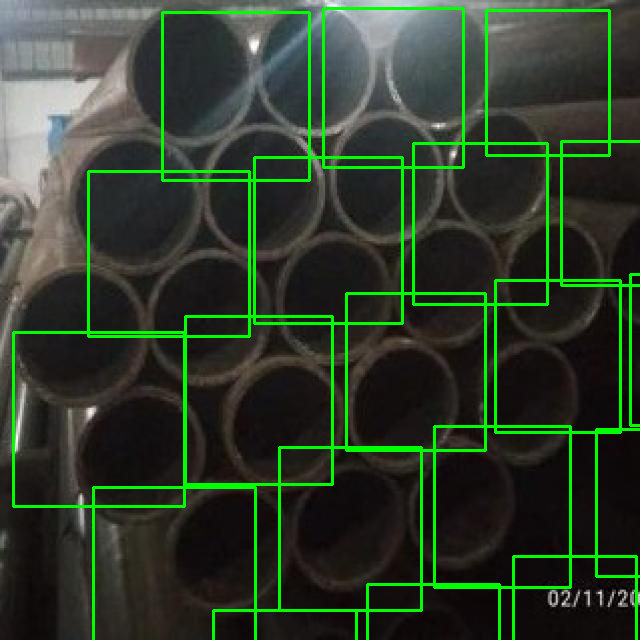

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Required for displaying images in Colab

# Load image
image_path = "/content/dataset/valid/IMG-20250130-WA0009_jpg.rf.c90f516f76c49ada9f342cad3d6c7b37.jpg"
image = cv2.imread(image_path)

# Ensure the image is loaded properly
if image is None:
    raise ValueError(f"Error loading image from {image_path}")

# Print model output details for debugging
print("Results shape:", results.shape)
print("First detection:", results[0])

# Handle different result formats
detections = results[0] if len(results.shape) == 3 else results  # Remove batch dimension if present

for box in detections:
    if len(box) == 6:  # Case where model outputs (x_min, y_min, x_max, y_max, score, class_id)
        x_min, y_min, x_max, y_max, score, class_id = box
        if score > 0.5:  # Only draw boxes with confidence > 50%
            cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

    elif len(box) == 4:  # Case where model only outputs (x_min, y_min, x_max, y_max)
        x_min, y_min, x_max, y_max = box
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

# Display image in Google Colab
cv2_imshow(image)
